In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [10]:
#maxEvents = 2000000
maxEvents = 500000
#maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.55, 1.7, 1.8, 1.98, 2.15, 2.5)
eta_bins = eta_bins[::-1]
pt_bins = (-0.5 , -0.38, -0.26, -0.15, -0.05, 0.05, 0.15, 0.26, 0.38, 0.5)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)
superstrip_size = 32

assert(len(eta_bins) == 6+1)
assert(len(pt_bins) == 9+1)

from six.moves import range, zip, map, filter

from incrementalstats import IncrementalStats

def find_sector(phi):  # phi in radians
  dphi = delta_phi(phi, np.pi/12)  # sector 1 starts at 15 deg
  dphi = int(np.floor(dphi/(np.pi/3)))  # divide by 60 deg
  if dphi < 0:
    sector = 7 + dphi
  else:
    sector = 1 + dphi
  return sector

def find_endcap(eta):
  endcap = +1 if eta >= 0. else -1
  return endcap

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def _find_bin_fast(x, bins):
  x = np.clip(x, bins[1], bins[2]-1e-8)
  binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
  return int(binx)

def find_eta_bin_13(eta, bins=(13,1.2,2.5)):
  return _find_bin_fast(abs(eta), bins)

def find_pt_bin_50(pt, bins=(50,-0.5,0.5)):
  return _find_bin_fast(pt, bins)

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,2,2] = 6  # RE2/2
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    return entry

find_emtf_layer = EMTFLayer()

class EMTFZone(object):
  def __init__(self):
    lut = np.zeros((5,5,5,6,2), dtype=np.int32) - 99  # (type, station, ring) -> [zone] x [min_theta,max_theta]
    lut[1,1,4][0] = 4,17   # ME1/1a
    lut[1,1,4][1] = 16,26  # ME1/1a
    lut[1,1,4][2] = 24,37  # ME1/1a
    lut[1,1,4][3] = 34,43  # ME1/1a
    lut[1,1,4][4] = 40,53  # ME1/1a
    lut[1,1,1][0] = 4,17   # ME1/1b
    lut[1,1,1][1] = 16,26  # ME1/1b
    lut[1,1,1][2] = 24,37  # ME1/1b
    lut[1,1,1][3] = 34,43  # ME1/1b
    lut[1,1,1][4] = 40,53  # ME1/1b
    lut[1,1,2][4] = 46,54  # ME1/2
    lut[1,1,2][5] = 52,88  # ME1/2
    lut[1,1,3][4] = 46,54  # ME1/3
    lut[1,1,3][5] = 52,88  # ME1/3
    #
    lut[1,2,1][0] = 4,17   # ME2/1
    lut[1,2,1][1] = 16,25  # ME2/1
    lut[1,2,1][2] = 24,36  # ME2/1
    lut[1,2,1][3] = 34,43  # ME2/1
    lut[1,2,1][4] = 40,49  # ME2/1
    lut[1,2,2][5] = 53,88  # ME2/2
    #
    lut[1,3,1][0] = 4,17   # ME3/1
    lut[1,3,1][1] = 16,25  # ME3/1
    lut[1,3,1][2] = 24,36  # ME3/1
    lut[1,3,1][3] = 34,40  # ME3/1
    lut[1,3,2][4] = 44,54  # ME3/2
    lut[1,3,2][5] = 52,88  # ME3/2
    #
    lut[1,4,1][0] = 4,17   # ME4/1
    lut[1,4,1][1] = 16,25  # ME4/1
    lut[1,4,1][2] = 24,35  # ME4/1
    lut[1,4,2][3] = 38,43  # ME4/2
    lut[1,4,2][4] = 41,54  # ME4/2
    lut[1,4,2][5] = 52,88  # ME4/2
    #
    lut[2,1,2][5] = 52,84  # RE1/2
    lut[2,2,2][5] = 56,76  # RE2/2
    lut[2,3,1][0] = 4,20   # RE3/1
    lut[2,3,1][1] = 20,24  # RE3/1
    lut[2,3,1][2] = 24,32  # RE3/1
    lut[2,3,2][3] = 40,40  # RE3/2
    lut[2,3,2][4] = 40,52  # RE3/2
    lut[2,3,2][5] = 48,84  # RE3/2
    lut[2,3,3][3] = 40,40  # RE3/3
    lut[2,3,3][4] = 40,52  # RE3/3
    lut[2,3,3][5] = 48,84  # RE3/3
    lut[2,4,1][0] = 8,16   # RE4/1
    lut[2,4,1][1] = 16,28  # RE4/1
    lut[2,4,1][2] = 24,28  # RE4/1
    lut[2,4,2][3] = 36,44  # RE4/2
    lut[2,4,2][4] = 44,52  # RE4/2
    lut[2,4,2][5] = 52,84  # RE4/2
    lut[2,4,3][3] = 36,44  # RE4/3
    lut[2,4,3][4] = 44,52  # RE4/3
    lut[2,4,3][5] = 52,84  # RE4/3
    #
    lut[3,1,1][1] = 17,26  # GE1/1
    lut[3,1,1][2] = 24,37  # GE1/1
    lut[3,1,1][3] = 35,45  # GE1/1
    lut[3,1,1][4] = 40,52  # GE1/1
    lut[3,2,1][0] = 7,19   # GE2/1
    lut[3,2,1][1] = 18,24  # GE2/1
    lut[3,2,1][2] = 23,35  # GE2/1
    lut[3,2,1][3] = 34,45  # GE2/1
    lut[3,2,1][4] = 40,46  # GE2/1
    #
    lut[4,1,1][0] = 4,17   # ME0
    lut[4,1,1][1] = 16,23  # ME0
    self.lut = lut
    
  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    answer = (entry[:,0] <= hit.emtf_theta) & (hit.emtf_theta <= entry[:,1])
    zones = np.nonzero(answer)
    if isinstance(zones, tuple):
      zones = zones[0]
    return zones

find_emtf_zones = EMTFZone()

class EMTFCheckMode(object):
  def __call__(self, mode):
    if hasattr(mode, 'mode'):
      mode = mode.mode
    return mode in (11,13,14,15)

is_good_emtf_mode = EMTFCheckMode()

class EMTFCheckLegit(object):
  def check_bx(self, hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0

  def check_quality(self, hit):
    if hit.type == kRPC:
      return hit.quality <= 9  # cluster width
    else:
      return True

  def __call__(self, hit):
    return self.check_bx(hit) and self.check_quality(hit)

is_good_emtf_hit = EMTFCheckLegit()

class EMTFZee(object):
  def __init__(self):
    self.lut = np.array([599.0, 696.8, 827.1, 937.5, 1027, 708.7, 790.9, 968.8, 1060, 566.4, 794.8, 539.3], dtype=np.float32)
    assert(self.lut.shape[0] == nlayers)
  
  def __call__(self, hit):
    return self.lut[hit.emtf_layer]

find_emtf_zee = EMTFZee()

class EMTFPhi(object):
  def __init__(self):
    pass
  
  def __call__(self, hit):
    if hit.type == kCSC:
      if hit.station == 1:
        if hit.ring == 1:
          bend_corr_lut = (-1.3861, 1.3692)  # ME1/1b (r,f)
        elif hit.ring == 4:
          bend_corr_lut = (-1.6419, 1.6012)  # ME1/1a (r,f)
        else:
          bend_corr_lut = (-0.9237, 0.8287)  # ME1/2 (r,f)
        bend_corr = bend_corr_lut[int(hit.fr)] * hit.bend
        bend_corr = bend_corr if hit.endcap == 1 else (bend_corr * -1)
        bend_corr = int(round(bend_corr))
        return hit.emtf_phi + bend_corr
      else:
        pass
    else:
      pass
    return hit.emtf_phi

find_emtf_phi = EMTFPhi()

class EMTFLayerPair(object):
  def __init__(self):
    self.lut = np.array([2, 2, 0, 0, 0, 0, 2, 3, 4, 0, 2, 0], dtype=np.int32)
    assert(self.lut.shape[0] == nlayers)

  def __call__(self, hit, zone):
    partner = self.lut[hit.emtf_layer]
    if zone >= 5:  # zones 5,6, use ME1/2
      if partner == 0:
        partner = 1
    return partner

find_emtf_layer_partner = EMTFLayerPair()

In [11]:
# Main analysis

def analysis(verbose=1):
  tree = load_pgun()
  
  out_part, out_hits = [], []
  
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector (using csc-only 'mode')
    sector_mode_array = np.zeros((12,), dtype=np.int32)
    sector_hits_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_hits_array.shape):
      sector_hits_array[ind] = []
    
    for ihit, hit in enumerate(evt.hits):
      assert(hit.emtf_phi < 5040)  # 84*60
      
      if hit.sim_tp1 == 0 and hit.sim_tp2 == 0:
        endsec = find_endsec(hit.endcap, hit.sector)
        if hit.type == kCSC:
          sector_mode_array[endsec] |= (1<<(4-hit.station))
        elif hit.type == kME0:
          sector_mode_array[endsec] |= (1<<(4-hit.station))
        sector_hits_array[endsec].append(hit)
    
    # Get the best sector
    best_sector = np.argmax(sector_mode_array)
    mode = sector_mode_array[best_sector]
    
    # Skip events without SingleMu modes
    if not is_good_emtf_mode(mode):
      continue
    
    # Get the particle info, road info
    ipt = find_pt_bin(part.invpt)
    ieta = find_eta_bin(part.eta)
    ipt50 = find_pt_bin_50(part.invpt)
    ieta13 = find_eta_bin_13(part.eta)
    
    # Get the hits
    sector_hits = sector_hits_array[best_sector]
    sector_hits = filter(is_good_emtf_hit, sector_hits)
    
    amap = {}  # zone -> hits
    
    # Loop over sector hits
    for ihit, hit in enumerate(sector_hits):
      hit.emtf_layer = find_emtf_layer(hit)
      assert(hit.emtf_layer != -99)
      
      hit.old_emtf_phi = hit.emtf_phi
      hit.emtf_zee = find_emtf_zee(hit)
      hit.emtf_phi = find_emtf_phi(hit)
      
      zones = find_emtf_zones(hit)
      for z in zones:
        amap.setdefault(np.asscalar(z), []).append(hit)
      continue  # end loop over sector_hits
    
    # Loop over map of zone -> hits
    ievt_part = []
    ievt_hits = []
    
    for k, v in amap.iteritems():
      zone = k
      hits = v
      
      mode = 0  # csc-only 'mode'
      for ihit, hit in enumerate(hits):
        if hit.type == kCSC:
          mode |= (1<<(4-hit.station))
        elif hit.type == kME0:
          mode |= (1<<(4-hit.station))
      
      if not is_good_emtf_mode(mode):
        continue
      
      # Output
      hits_array = np.zeros((80,3), dtype=np.int32) - 99  # output up to 80 hits
      for ihit, hit in enumerate(hits):
        if ihit == 80:
          break
        hits_array[ihit] = (hit.emtf_layer, hit.emtf_phi, hit.old_emtf_phi)
        
      ievt_part.append((ipt, ieta, ipt50, ieta13, zone, mode))
      ievt_hits.append(hits_array)
      continue  # end loop over map of zone -> hits
    
    # Verbose
    if ievt < 20:
      ievt_nhits = [(x[:,0] != -99).sum() for x in ievt_hits]
      print ievt, part.pt, ievt_part, ievt_nhits
    
    # Output
    out_part += ievt_part
    out_hits += ievt_hits
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part, dtype=np.int32), np.asarray(out_hits, dtype=np.int32)

In [12]:
%%time

# Run analysis
out_part, out_hits = analysis()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
0 2.2441008091 [(0, 1, 2, 8, 1, 14)] [7]
2 2.83313345909 [(7, 0, 42, 11, 0, 14)] [8]
4 6.14469432831 [(2, 5, 16, 1, 5, 15)] [8]
5 5.51849126816 [(6, 3, 34, 5, 3, 15)] [9]
6 2.62028098106 [(8, 1, 44, 8, 1, 11)] [8]
7 6.84316205978 [(3, 1, 17, 8, 1, 15)] [7]
8 2.37840628624 [(8, 1, 46, 8, 1, 15)] [11]
9 2.898209095 [(1, 0, 7, 11, 0, 14)] [8]
10 2.72461438179 [(7, 0, 43, 11, 0, 15)] [8]
11 3.73449015617 [(7, 2, 38, 6, 2, 15)] [9]
12 52.140007019 [(4, 0, 24, 11, 0, 15)] [8]
14 8.361577034 [(3, 5, 19, 2, 5, 15)] [6]
15 7.21895551682 [(3, 3, 18, 5, 3, 15)] [9]
16 25.9081859589 [(4, 4, 23, 4, 3, 13), (4, 4, 23, 4, 4, 13)] [8, 9]
17 2.27322983742 [(0, 0, 3, 9, 0, 13), (0, 0, 3, 9, 1, 13)] [6, 8]
18 16.2746582031 [(5, 2, 28, 7, 2, 13)] [7]
19 10.1214160919 [(5, 3, 29, 5, 3, 13), (5, 3, 29, 5, 4, 13)] [7, 7]
Processing event: 10000
Processing event: 20000
Processing event: 30000
Processing event: 40000
Proces

In [13]:
print out_part.shape, out_hits.shape

(401239, 6) (401239, 80, 3) int32 int32


### Find mean deflection angles

In [158]:
%%time

_get_emtf_phi = lambda x: x[1]

patterns_match_pre = np.empty((50, 13, nlayers), dtype=np.object)  # used for matching
for ind in np.ndindex(patterns_match_pre.shape):
  patterns_match_pre[ind] = []

# Loop over part and hits
for part, hits in zip(out_part, out_hits):
  (ipt, ieta, ipt50, ieta13, zone, mode) = part
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    if hit[0] != -99:
      amap.setdefault(hit[0], []).append(hit)

  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer

  #lut = np.array([2, 2, 0, 0, 0, 0, 2, 3, 4, 0, 2, 0], dtype=np.int32)
  lut = find_emtf_layer_partner.lut
  
  for k, v in amap.iteritems():
    emtf_layer = k
    hit_phi1 = _get_emtf_phi(v)
    
    emtf_layer_partner = lut[emtf_layer]
    if ieta13 <= 3:  # eta <= 1.6
      if emtf_layer_partner == 0:
        emtf_layer_partner = 1
    
    if emtf_layer_partner in amap:
      hit_phi2 = _get_emtf_phi(amap[emtf_layer_partner])
      patterns_match_pre[ipt50, ieta13, emtf_layer].append(hit_phi1 - hit_phi2)
  continue  # end loop over part and hits

CPU times: user 2min 57s, sys: 3.3 s, total: 3min 1s
Wall time: 2min 53s


In [159]:
lengths = [len(patterns_match_pre[ind]) for ind in np.ndindex(patterns_match_pre.shape)]
print np.percentile(lengths, [10,20,30,40,50,60,70,80,90], overwrite_input=True)

[  0.    0.    2.   69.  343.  503.4 594.  658.  726. ]


In [160]:
patterns_match_pre_1 = np.zeros(patterns_match_pre.shape, dtype=np.int32)  # used for matching
for ind in np.ndindex(patterns_match_pre.shape):
  if len(patterns_match_pre[ind]) > 300:
    patterns_match_pre_1[ind] = np.percentile(patterns_match_pre[ind], [50], overwrite_input=True)
    print ind, patterns_match_pre_1[ind]

(0, 7, 0) -409
(0, 7, 2) 409
(0, 7, 3) 334
(0, 7, 4) 170
(0, 7, 7) -50
(0, 7, 8) -52
(0, 7, 9) -87
(0, 7, 10) -14
(0, 8, 0) -370
(0, 8, 2) 370
(0, 8, 3) 360
(0, 8, 4) 260
(0, 8, 7) -26
(0, 8, 8) -32
(0, 8, 10) -19
(0, 8, 11) -138
(0, 9, 0) -335
(0, 9, 2) 335
(0, 9, 3) 361
(0, 9, 4) 314
(0, 9, 7) -12
(0, 9, 8) -16
(0, 9, 10) -24
(0, 9, 11) -123
(0, 10, 0) -288
(0, 10, 2) 288
(0, 10, 3) 328
(0, 10, 4) 305
(0, 10, 7) -2
(0, 10, 8) -8
(0, 10, 10) -24
(0, 10, 11) -113
(0, 11, 0) -246
(0, 11, 2) 246
(0, 11, 3) 301
(0, 11, 4) 288
(0, 11, 7) 2
(0, 11, 8) -4
(0, 11, 10) -23
(0, 11, 11) -99
(1, 6, 0) -418
(1, 6, 2) 418
(1, 7, 0) -386
(1, 7, 2) 386
(1, 7, 3) 338
(1, 7, 4) 200
(1, 7, 7) -38
(1, 7, 8) -42
(1, 7, 9) -83
(1, 7, 10) -13
(1, 8, 0) -356
(1, 8, 2) 356
(1, 8, 3) 365
(1, 8, 4) 300
(1, 8, 7) -21
(1, 8, 8) -24
(1, 8, 9) -76
(1, 8, 10) -19
(1, 8, 11) -133
(1, 9, 0) -310
(1, 9, 2) 310
(1, 9, 3) 335
(1, 9, 4) 295
(1, 9, 7) -11
(1, 9, 8) -14
(1, 9, 10) -22
(1, 9, 11) -118
(1, 10, 0) -278
(1, 10,

(9, 8, 2) 233
(9, 8, 3) 259
(9, 8, 4) 245
(9, 8, 7) -4
(9, 8, 8) -4
(9, 8, 9) -49
(9, 8, 10) -17
(9, 8, 11) -88
(9, 9, 0) -200
(9, 9, 2) 200
(9, 9, 3) 230
(9, 9, 4) 226
(9, 9, 7) 0
(9, 9, 8) -2
(9, 9, 10) -15
(9, 9, 11) -75
(9, 10, 0) -177
(9, 10, 2) 177
(9, 10, 3) 212
(9, 10, 4) 214
(9, 10, 7) 2
(9, 10, 8) 0
(9, 10, 10) -16
(9, 10, 11) -69
(9, 11, 0) -148
(9, 11, 2) 148
(9, 11, 3) 185
(9, 11, 4) 196
(9, 11, 7) 4
(9, 11, 8) 0
(9, 11, 10) -14
(9, 11, 11) -59
(10, 0, 1) -62
(10, 0, 2) 62
(10, 0, 3) -28
(10, 0, 4) -147
(10, 0, 5) 9
(10, 0, 6) 9
(10, 0, 7) -42
(10, 0, 8) -45
(10, 1, 1) -105
(10, 1, 2) 105
(10, 1, 3) 91
(10, 1, 4) 48
(10, 1, 5) 28
(10, 1, 6) -9
(10, 1, 7) -16
(10, 1, 8) -17
(10, 2, 1) -121
(10, 2, 2) 121
(10, 2, 3) 129
(10, 2, 4) 105
(10, 2, 5) 22
(10, 2, 6) -17
(10, 2, 7) -9
(10, 2, 8) -9
(10, 3, 3) 130
(10, 3, 4) 99
(10, 3, 7) -12
(10, 3, 8) -16
(10, 4, 0) -322
(10, 4, 2) 322
(10, 4, 4) 279
(10, 4, 8) -17
(10, 4, 9) -71
(10, 4, 10) -12
(10, 5, 0) -294
(10, 5, 2) 294
(10, 

(16, 2, 8) -4
(16, 3, 3) 88
(16, 3, 4) 85
(16, 3, 5) 11
(16, 3, 7) -1
(16, 3, 8) -3
(16, 4, 0) -182
(16, 4, 2) 182
(16, 4, 3) 198
(16, 4, 4) 190
(16, 4, 7) 0
(16, 4, 8) -4
(16, 4, 9) -41
(16, 4, 10) -10
(16, 5, 0) -169
(16, 5, 2) 169
(16, 5, 3) 179
(16, 5, 4) 180
(16, 5, 7) -2
(16, 5, 9) -36
(16, 5, 10) -9
(16, 6, 0) -153
(16, 6, 2) 153
(16, 6, 3) 167
(16, 6, 4) 167
(16, 6, 7) 0
(16, 6, 9) -32
(16, 6, 10) -10
(16, 7, 0) -135
(16, 7, 2) 135
(16, 7, 3) 153
(16, 7, 4) 152
(16, 7, 7) 0
(16, 7, 8) 0
(16, 7, 9) -28
(16, 7, 10) -10
(16, 8, 0) -120
(16, 8, 2) 120
(16, 8, 3) 140
(16, 8, 4) 142
(16, 8, 7) 0
(16, 8, 8) 0
(16, 8, 9) -25
(16, 8, 10) -10
(16, 8, 11) -45
(16, 9, 0) -107
(16, 9, 2) 107
(16, 9, 3) 126
(16, 9, 4) 131
(16, 9, 7) 0
(16, 9, 8) 0
(16, 9, 9) -23
(16, 9, 10) -9
(16, 9, 11) -41
(16, 10, 0) -94
(16, 10, 2) 94
(16, 10, 3) 112
(16, 10, 4) 117
(16, 10, 7) 2
(16, 10, 8) 0
(16, 10, 10) -8
(16, 10, 11) -37
(16, 11, 0) -81
(16, 11, 2) 81
(16, 11, 3) 103
(16, 11, 4) 108
(16, 11, 7) 4
(

(23, 1, 6) 0
(23, 1, 7) 0
(23, 1, 8) 0
(23, 2, 1) -12
(23, 2, 2) 12
(23, 2, 3) 16
(23, 2, 4) 16
(23, 2, 5) 1
(23, 2, 6) -1
(23, 2, 7) 0
(23, 2, 8) 0
(23, 3, 1) -12
(23, 3, 2) 12
(23, 3, 3) 16
(23, 3, 4) 16
(23, 3, 5) 2
(23, 3, 6) -4
(23, 3, 7) 0
(23, 3, 8) 0
(23, 4, 0) -29
(23, 4, 2) 29
(23, 4, 3) 33
(23, 4, 4) 33
(23, 4, 7) 0
(23, 4, 8) 0
(23, 4, 9) -7
(23, 4, 10) -3
(23, 5, 0) -28
(23, 5, 2) 28
(23, 5, 3) 30
(23, 5, 4) 33
(23, 5, 7) 0
(23, 5, 8) 0
(23, 5, 9) -6
(23, 5, 10) -2
(23, 6, 0) -25
(23, 6, 2) 25
(23, 6, 3) 29
(23, 6, 4) 30
(23, 6, 7) 0
(23, 6, 9) -5
(23, 6, 10) -2
(23, 7, 0) -22
(23, 7, 2) 22
(23, 7, 3) 26
(23, 7, 4) 26
(23, 7, 7) 0
(23, 7, 8) 0
(23, 7, 9) -5
(23, 7, 10) -2
(23, 8, 0) -21
(23, 8, 2) 21
(23, 8, 3) 25
(23, 8, 4) 26
(23, 8, 7) 0
(23, 8, 8) 0
(23, 8, 9) -4
(23, 8, 10) -2
(23, 8, 11) -7
(23, 9, 0) -17
(23, 9, 2) 17
(23, 9, 3) 21
(23, 9, 4) 23
(23, 9, 7) 0
(23, 9, 8) 0
(23, 9, 9) -4
(23, 9, 10) -1
(23, 9, 11) -7
(23, 10, 0) -15
(23, 10, 2) 15
(23, 10, 3) 19
(23, 1

(29, 3, 7) 0
(29, 3, 8) 0
(29, 4, 0) 93
(29, 4, 2) -93
(29, 4, 3) -102
(29, 4, 4) -103
(29, 4, 7) 0
(29, 4, 8) 0
(29, 4, 9) 20
(29, 4, 10) 5
(29, 5, 0) 88
(29, 5, 2) -88
(29, 5, 3) -95
(29, 5, 4) -102
(29, 5, 7) 0
(29, 5, 8) 1
(29, 5, 9) 19
(29, 5, 10) 6
(29, 6, 0) 78
(29, 6, 2) -78
(29, 6, 3) -88
(29, 6, 4) -87
(29, 6, 7) 0
(29, 6, 9) 17
(29, 6, 10) 5
(29, 7, 0) 70
(29, 7, 2) -70
(29, 7, 3) -79
(29, 7, 4) -82
(29, 7, 7) 0
(29, 7, 8) 0
(29, 7, 9) 14
(29, 7, 10) 5
(29, 8, 0) 63
(29, 8, 2) -63
(29, 8, 3) -73
(29, 8, 4) -76
(29, 8, 7) 0
(29, 8, 8) 0
(29, 8, 9) 13
(29, 8, 10) 5
(29, 8, 11) 24
(29, 9, 0) 57
(29, 9, 2) -57
(29, 9, 3) -69
(29, 9, 4) -72
(29, 9, 7) 0
(29, 9, 8) 0
(29, 9, 9) 13
(29, 9, 10) 5
(29, 9, 11) 22
(29, 10, 0) 49
(29, 10, 2) -49
(29, 10, 3) -59
(29, 10, 4) -63
(29, 10, 7) -1
(29, 10, 8) 0
(29, 10, 10) 5
(29, 10, 11) 18
(29, 11, 0) 44
(29, 11, 2) -44
(29, 11, 3) -56
(29, 11, 4) -60
(29, 11, 7) -2
(29, 11, 8) 0
(29, 11, 10) 4
(29, 11, 11) 17
(30, 0, 1) 35
(30, 0, 2) -35
(

(36, 4, 9) 56
(36, 4, 10) 12
(36, 5, 0) 235
(36, 5, 2) -235
(36, 5, 3) -242
(36, 5, 4) -227
(36, 5, 7) 6
(36, 5, 9) 51
(36, 5, 10) 12
(36, 6, 0) 209
(36, 6, 2) -209
(36, 6, 3) -223
(36, 6, 4) -213
(36, 6, 7) 4
(36, 6, 9) 44
(36, 6, 10) 12
(36, 7, 0) 188
(36, 7, 2) -188
(36, 7, 3) -208
(36, 7, 4) -200
(36, 7, 7) 0
(36, 7, 8) 4
(36, 7, 9) 40
(36, 7, 10) 13
(36, 8, 0) 168
(36, 8, 2) -168
(36, 8, 3) -189
(36, 8, 4) -186
(36, 8, 7) 0
(36, 8, 8) 0
(36, 8, 9) 35
(36, 8, 10) 12
(36, 8, 11) 63
(36, 9, 0) 151
(36, 9, 2) -151
(36, 9, 3) -179
(36, 9, 4) -185
(36, 9, 7) -2
(36, 9, 8) 0
(36, 9, 9) 31
(36, 9, 10) 12
(36, 9, 11) 57
(36, 10, 0) 130
(36, 10, 2) -130
(36, 10, 3) -155
(36, 10, 4) -158
(36, 10, 7) -4
(36, 10, 8) 0
(36, 10, 10) 12
(36, 10, 11) 49
(36, 11, 0) 110
(36, 11, 2) -110
(36, 11, 3) -133
(36, 11, 4) -138
(36, 11, 7) -4
(36, 11, 8) 0
(36, 11, 10) 11
(36, 11, 11) 43
(37, 0, 1) 59
(37, 0, 2) -59
(37, 0, 3) -17
(37, 0, 4) 46
(37, 0, 5) -16
(37, 0, 6) -4
(37, 0, 7) 25
(37, 0, 8) 25
(37, 

(43, 8, 11) 106
(43, 9, 0) 245
(43, 9, 2) -245
(43, 9, 3) -273
(43, 9, 4) -268
(43, 9, 7) 2
(43, 9, 8) 4
(43, 9, 10) 18
(43, 9, 11) 94
(43, 10, 0) 215
(43, 10, 2) -215
(43, 10, 3) -246
(43, 10, 4) -243
(43, 10, 7) 0
(43, 10, 8) 2
(43, 10, 10) 18
(43, 10, 11) 82
(43, 11, 0) 188
(43, 11, 2) -188
(43, 11, 3) -222
(43, 11, 4) -225
(43, 11, 7) -4
(43, 11, 8) 0
(43, 11, 10) 18
(43, 11, 11) 73
(44, 2, 3) -145
(44, 2, 4) -74
(44, 2, 7) 25
(44, 2, 8) 29
(44, 5, 0) 387
(44, 5, 2) -387
(44, 5, 3) -300
(44, 5, 4) -144
(44, 5, 7) 50
(44, 5, 9) 86
(44, 5, 10) 4
(44, 6, 0) 365
(44, 6, 2) -365
(44, 6, 3) -325
(44, 6, 4) -222
(44, 6, 7) 30
(44, 6, 8) 34
(44, 6, 9) 80
(44, 6, 10) 11
(44, 7, 0) 333
(44, 7, 2) -333
(44, 7, 3) -328
(44, 7, 4) -278
(44, 7, 7) 16
(44, 7, 8) 20
(44, 7, 9) 70
(44, 7, 10) 16
(44, 8, 0) 305
(44, 8, 2) -305
(44, 8, 3) -323
(44, 8, 4) -297
(44, 8, 7) 8
(44, 8, 8) 12
(44, 8, 9) 62
(44, 8, 10) 19
(44, 8, 11) 113
(44, 9, 0) 258
(44, 9, 2) -258
(44, 9, 3) -283
(44, 9, 4) -269
(44, 9, 

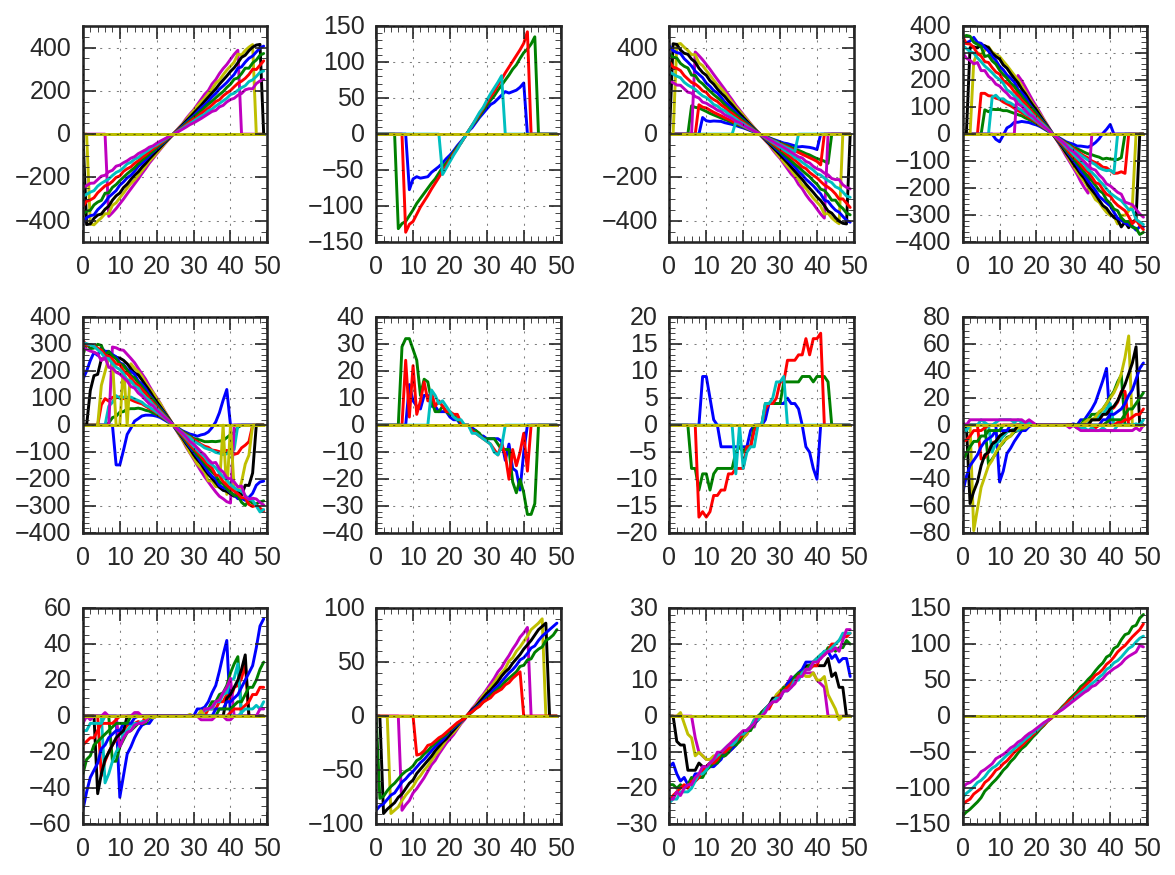

In [161]:
# Styling
plt.style.use('tdrstyle.mplstyle')

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(8,6), tight_layout=True)

for i in xrange(nlayers):
  for j in xrange(13):
    axs[i/4,i%4].plot(np.arange(50), patterns_match_pre_1[:,j,i])
plt.show()

### Find pattern windows

In [163]:
%%time

_get_emtf_phi = lambda x: x[1]

patterns_phi = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)
patterns_match = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)
for ind in np.ndindex(patterns_phi.shape):
  patterns_phi[ind] = []
  patterns_match[ind] = []

# Loop over part and hits
for part, hits in zip(out_part, out_hits):
  (ipt, ieta, ipt50, ieta13, zone, mode) = part
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    if hit[0] != -99:
      amap.setdefault(hit[0], []).append(hit)
      
  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer

  key_hit_phi = None
  if 2 in amap:    # use ME2
    key_hit_phi = _get_emtf_phi(amap[2])
  elif 3 in amap:  # alternatively, use ME3
    key_hit_phi = _get_emtf_phi(amap[3])
    key_hit_phi -= patterns_match_pre_1[ipt50, ieta13, 3]
    key_hit_phi += patterns_match_pre_1[ipt50, ieta13, 2]
  elif 4 in amap:  # alternatively, use ME4
    key_hit_phi = _get_emtf_phi(amap[4])
    key_hit_phi -= patterns_match_pre_1[ipt50, ieta13, 4]
    key_hit_phi += patterns_match_pre_1[ipt50, ieta13, 2]

  if key_hit_phi is None:
    continue
    
  #lut = np.array([2, 2, 0, 0, 0, 0, 2, 3, 4, 0, 2, 0], dtype=np.int32)
  lut = find_emtf_layer_partner.lut
  
  for k, v in amap.iteritems():
    emtf_layer = k
    hit_phi1 = _get_emtf_phi(v)
    patterns_phi[ipt, ieta, emtf_layer].append(hit_phi1 - key_hit_phi)
    
    emtf_layer_partner = lut[emtf_layer]
    if zone >= 5:  # zones 5,6, use ME1/2
      if emtf_layer_partner == 0:
        emtf_layer_partner = 1
    
    if emtf_layer_partner in amap:
      hit_phi2 = _get_emtf_phi(amap[emtf_layer_partner])
      patterns_match[ipt, ieta, emtf_layer].append(hit_phi1 - hit_phi2)
  continue  # end loop over part and hits

CPU times: user 3min, sys: 3.46 s, total: 3min 3s
Wall time: 2min 56s


In [164]:
valid_layers = np.zeros(patterns_phi.shape, dtype=np.bool)
valid_layers[:, 0, [0,2,3,4,7,8,10,11]]   = True
valid_layers[:, 1, [0,2,3,4,7,8,9,10,11]] = True
valid_layers[:, 2, [0,2,3,4,7,8,9,10]]    = True
valid_layers[:, 3, [0,2,3,4,7,8,9,10]]    = True
valid_layers[:, 4, [0,1,2,3,4,7,8,9,10]]  = True
valid_layers[:, 5, [1,2,3,4,5,6,7,8]]     = True

patterns_phi_1 = np.zeros(patterns_phi.shape + (63,), dtype=np.int32)
for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    #print ind, np.percentile(patterns_phi[ind], [5,50,95], overwrite_input=True)
    patterns_phi_1[ind], _ = np.histogram(patterns_phi[ind], bins=63, range=(-0.5*63*superstrip_size,0.5*63*superstrip_size,))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


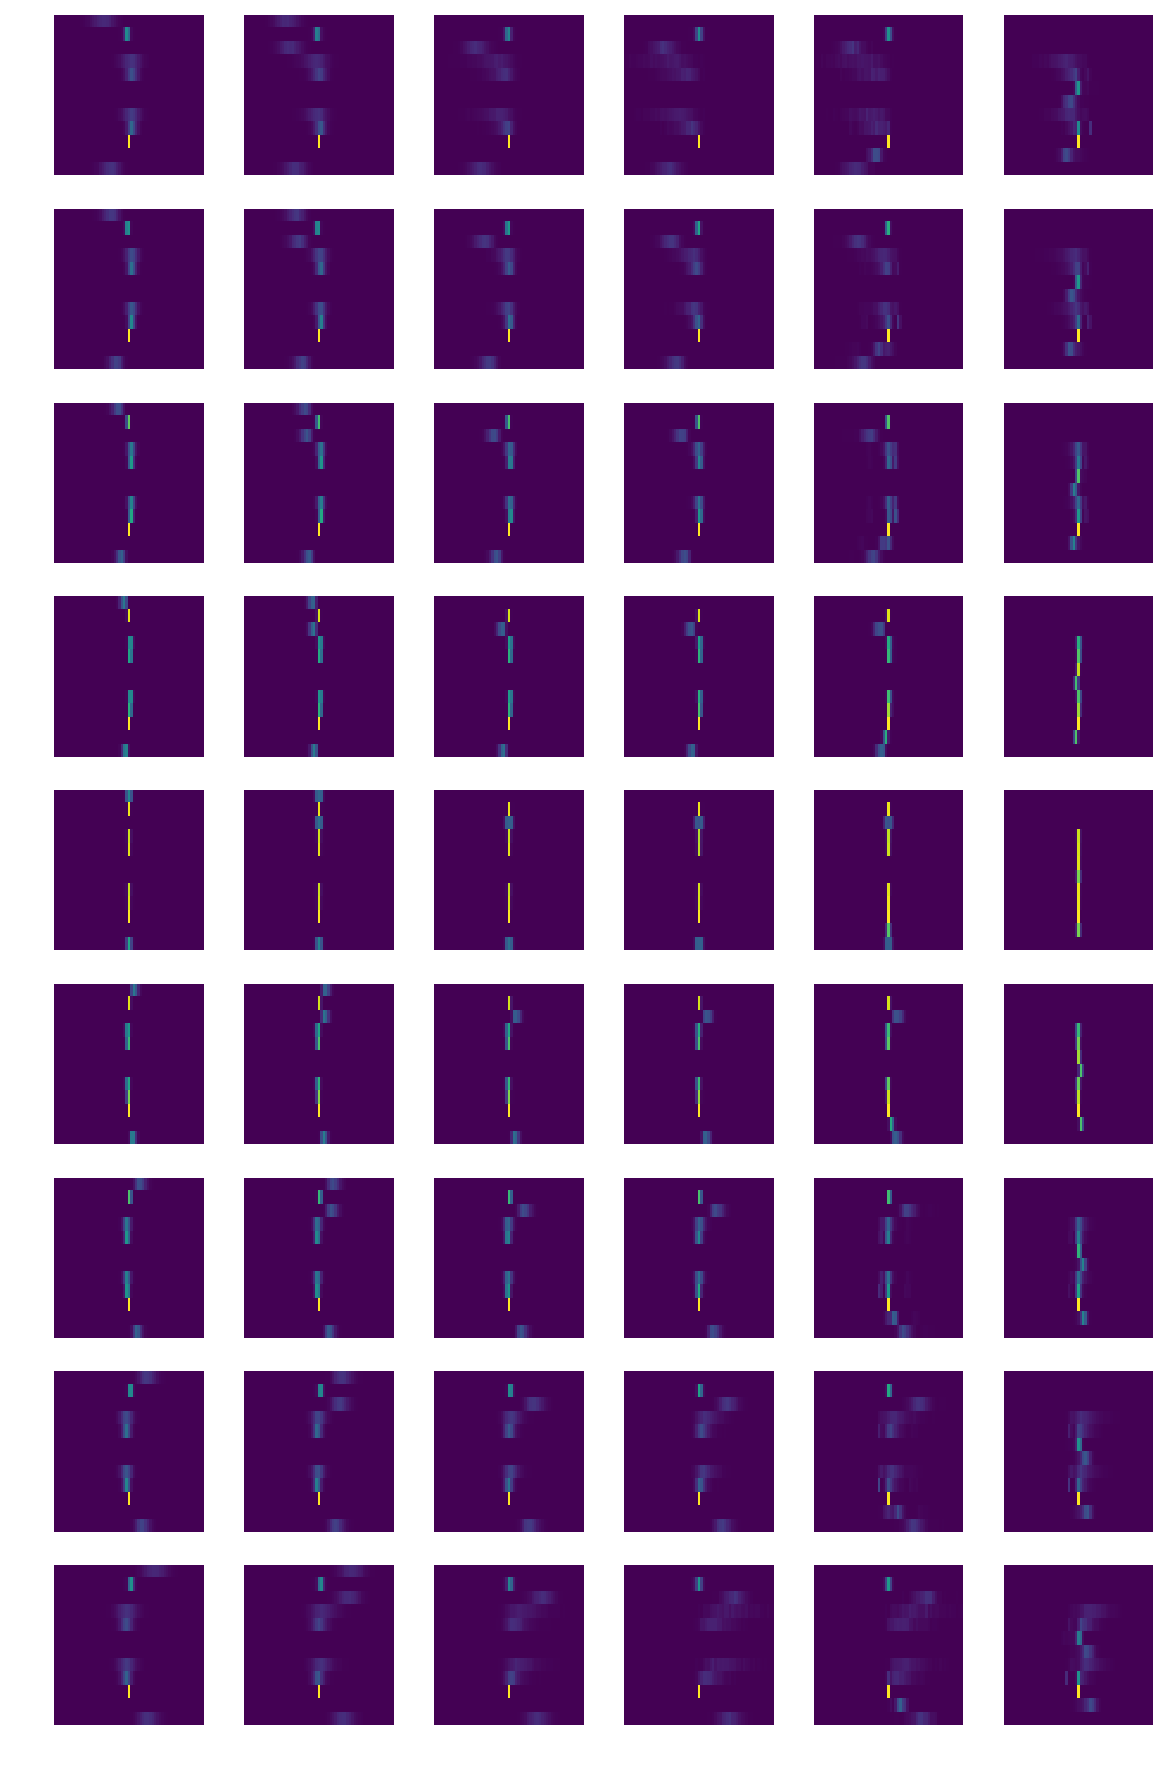

In [165]:
fig, axs = plt.subplots(ncols=6, nrows=9, figsize=(8,8./6*9), tight_layout=True, sharex=True, sharey=True)

for i in xrange(9):
  for j in xrange(6):
    norm = patterns_phi_1[i,j,:].sum(axis=1)
    img = np.true_divide(patterns_phi_1[i,j,:], norm[:,np.newaxis])
    img[np.isnan(img)] = 0
    
    axs[i,j].imshow(img, origin='lower', interpolation='nearest', aspect='auto')
    axs[i,j].axis('off')
    
plt.show()

In [171]:
patterns_phi_2 = np.zeros(patterns_phi.shape + (3,), dtype=np.int32)
for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    #print ind, np.percentile(patterns_phi[ind], [5,50,95], overwrite_input=True)
    x, _ = np.histogram(patterns_phi[ind], bins=63, range=(-0.5*63*superstrip_size,0.5*63*superstrip_size,))
    norm = x.sum()
    x = np.true_divide(x, norm)
    x[np.isnan(x)] = 0
    
    try:
      y = np.where(x > 0.01)[0]
      y = y[0], y[-1]
    except:
      y = 0, 0
    
    z = np.percentile(patterns_phi[ind], [2.5,50,97.5], overwrite_input=True)
    z = np.round(np.true_divide(z, superstrip_size)) + 31
    print ind, y, z
    
    patterns_phi_2[ind] = y[0], z[1], y[1]

(0, 0, 0) (17, 29) [17. 23. 28.]
(0, 0, 2) (31, 31) [31. 31. 31.]
(0, 0, 3) (29, 36) [29. 32. 35.]
(0, 0, 4) (26, 37) [27. 32. 37.]
(0, 0, 7) (28, 36) [28. 32. 36.]
(0, 0, 8) (25, 38) [25. 32. 38.]
(0, 0, 10) (28, 32) [29. 30. 32.]
(0, 0, 11) (13, 27) [13. 20. 27.]
(0, 1, 0) (14, 27) [14. 21. 27.]
(0, 1, 2) (31, 31) [31. 31. 31.]
(0, 1, 3) (27, 35) [27. 31. 35.]
(0, 1, 4) (22, 36) [22. 30. 36.]
(0, 1, 7) (25, 36) [25. 31. 35.]
(0, 1, 8) (20, 37) [19. 29. 37.]
(0, 1, 9) (12, 26) [12. 19. 25.]
(0, 1, 10) (28, 33) [28. 30. 32.]
(0, 1, 11) (10, 25) [10. 17. 24.]
(0, 2, 0) (12, 26) [12. 19. 26.]
(0, 2, 2) (31, 31) [31. 31. 31.]
(0, 2, 3) (22, 34) [22. 30. 34.]
(0, 2, 4) (14, 33) [11. 26. 33.]
(0, 2, 7) (19, 34) [18. 28. 34.]
(0, 2, 8) (13, 34) [ 6. 25. 34.]
(0, 2, 9) (11, 24) [10. 17. 24.]
(0, 2, 10) (28, 33) [28. 31. 33.]
(0, 3, 0) (11, 25) [11. 18. 25.]
(0, 3, 2) (31, 31) [31. 31. 31.]
(0, 3, 3) (15, 33) [17. 27. 32.]
(0, 3, 4) (5, 33) [ 5. 21. 31.]
(0, 3, 7) (13, 33) [13. 25. 31.]
(0, 3,

(6, 0, 3) (29, 32) [29. 30. 31.]
(6, 0, 4) (28, 32) [28. 30. 32.]
(6, 0, 7) (28, 32) [29. 30. 31.]
(6, 0, 8) (28, 33) [28. 30. 32.]
(6, 0, 10) (31, 32) [31. 31. 32.]
(6, 0, 11) (33, 40) [33. 36. 39.]
(6, 1, 0) (33, 39) [33. 35. 39.]
(6, 1, 2) (31, 31) [31. 31. 31.]
(6, 1, 3) (29, 32) [29. 30. 31.]
(6, 1, 4) (28, 33) [28. 30. 32.]
(6, 1, 7) (29, 32) [29. 30. 32.]
(6, 1, 8) (28, 33) [28. 30. 33.]
(6, 1, 9) (33, 41) [34. 36. 40.]
(6, 1, 10) (30, 32) [31. 31. 32.]
(6, 1, 11) (34, 42) [34. 37. 41.]
(6, 2, 0) (34, 40) [34. 36. 40.]
(6, 2, 2) (31, 31) [31. 31. 31.]
(6, 2, 3) (29, 32) [29. 31. 32.]
(6, 2, 4) (28, 33) [29. 31. 33.]
(6, 2, 7) (29, 33) [29. 31. 32.]
(6, 2, 8) (28, 34) [28. 31. 33.]
(6, 2, 9) (34, 42) [35. 37. 42.]
(6, 2, 10) (31, 32) [31. 31. 32.]
(6, 3, 0) (34, 41) [35. 37. 41.]
(6, 3, 2) (31, 31) [31. 31. 31.]
(6, 3, 3) (29, 33) [29. 31. 32.]
(6, 3, 4) (28, 34) [29. 31. 34.]
(6, 3, 7) (29, 33) [29. 31. 33.]
(6, 3, 8) (28, 35) [29. 31. 35.]
(6, 3, 9) (35, 43) [36. 38. 43.]
(6, 3

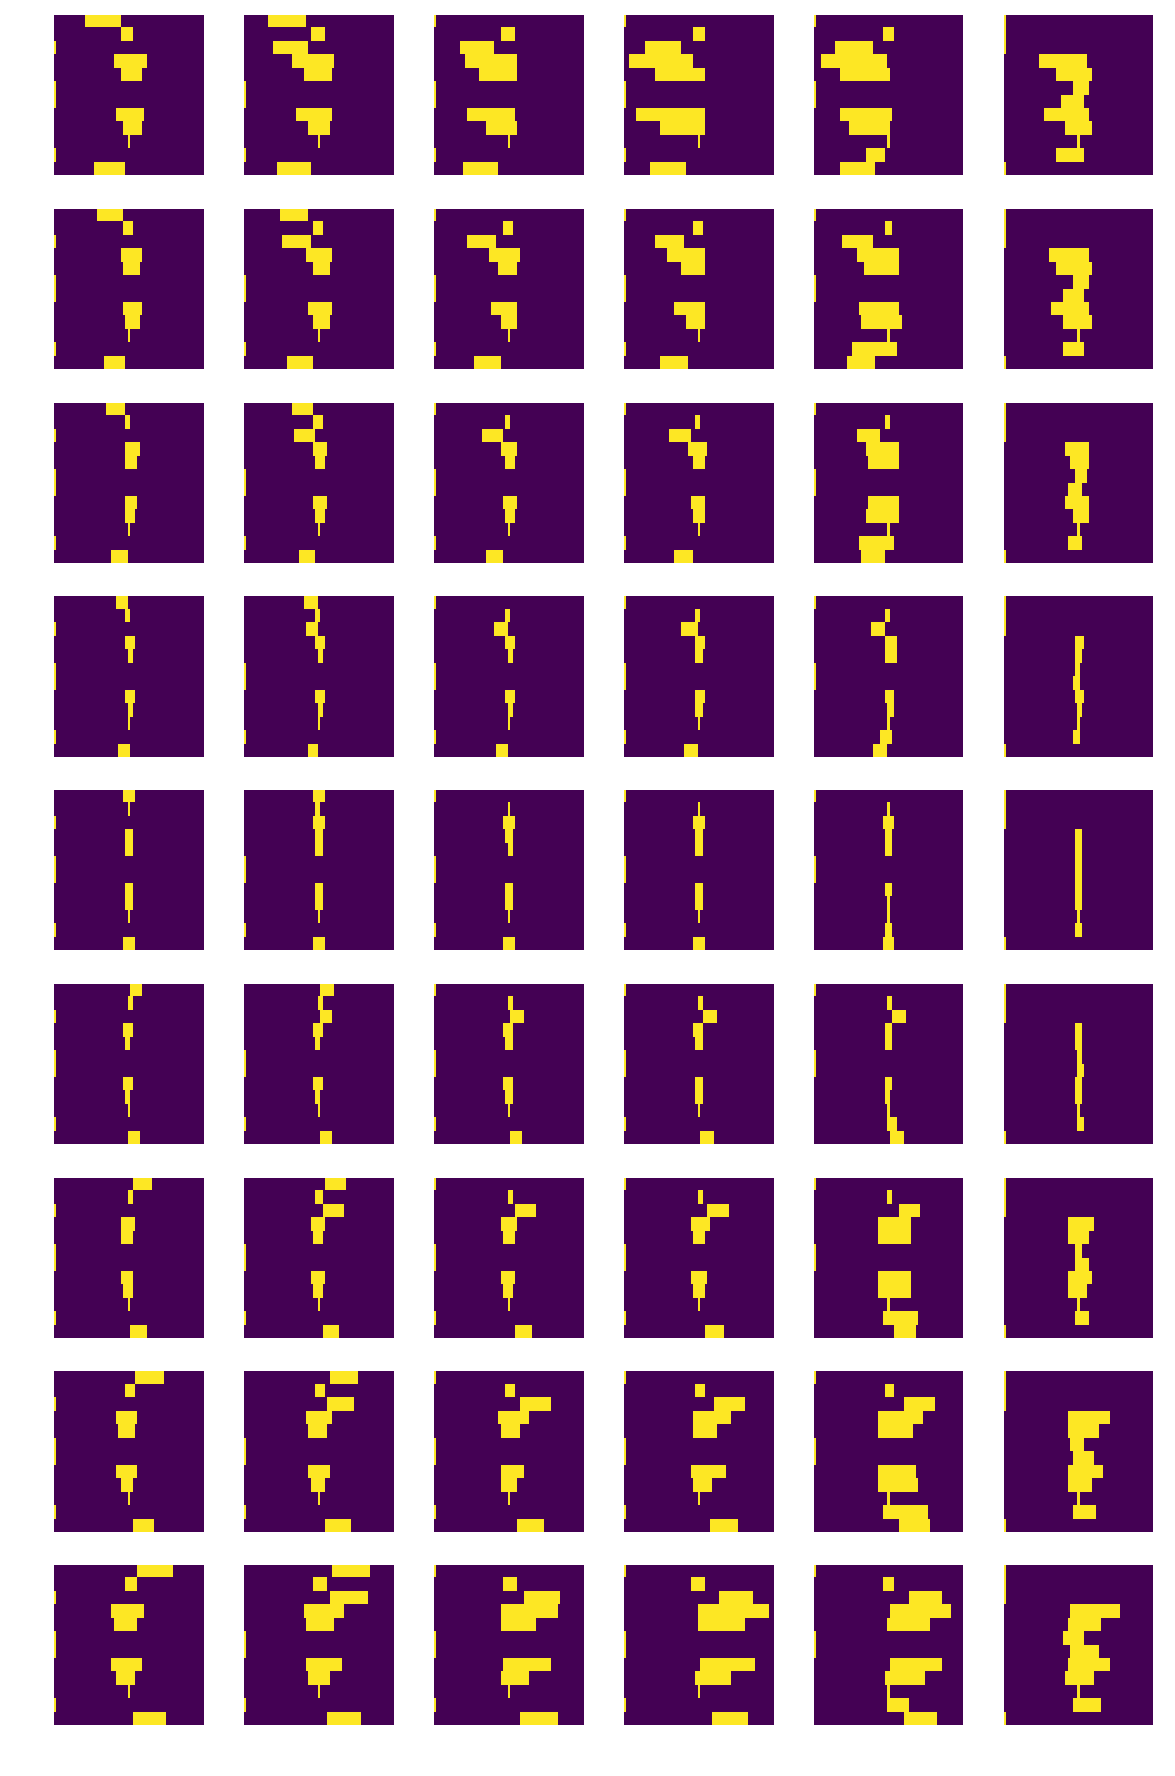

In [172]:
fig, axs = plt.subplots(ncols=6, nrows=9, figsize=(8,8./6*9), tight_layout=True, sharex=True, sharey=True)

for i in xrange(9):
  for j in xrange(6):
    
    img = np.zeros((nlayers, 63), dtype=np.float32)
    for k in xrange(nlayers):
      x0, x1 = patterns_phi_2[i,j,k,0], patterns_phi_2[i,j,k,2]
      img[k, slice(x0,x1+1)] = 1

    axs[i,j].imshow(img, origin='lower', interpolation='nearest', aspect='auto')
    axs[i,j].axis('off')
    
plt.show()

In [173]:
patterns_match_1 = np.zeros(patterns_match.shape + (3,), dtype=np.int32)  # used for matching

for ind in np.ndindex(patterns_match.shape):
  if valid_layers[ind]:
    patterns_match_1[ind] = np.percentile(patterns_match[ind], [5, 50, 95], overwrite_input=True)
    print ind, patterns_match_1[ind]

(0, 0, 0) [-406 -250 -115]
(0, 0, 2) [115 250 406]
(0, 0, 3) [ 93 288 505]
(0, 0, 4) [ 35 283 542]
(0, 0, 7) [-30   0  24]
(0, 0, 8) [-38  -4  18]
(0, 0, 10) [-59 -21   2]
(0, 0, 11) [-146  -97  -54]
(0, 1, 0) [-494 -326 -174]
(0, 1, 2) [174 326 494]
(0, 1, 3) [110 338 572]
(0, 1, 4) [-11 288 568]
(0, 1, 7) [-58 -12  16]
(0, 1, 8) [-66 -16  12]
(0, 1, 9) [-97 -69 -43]
(0, 1, 10) [-58 -20  10]
(0, 1, 11) [-164 -122  -75]
(0, 2, 0) [-554 -381 -219]
(0, 2, 2) [219 381 554]
(0, 2, 3) [ 38 332 575]
(0, 2, 4) [-227  212  528]
(0, 2, 7) [-138  -38    0]
(0, 2, 8) [-130  -38    0]
(0, 2, 9) [-107  -82  -53]
(0, 2, 10) [-51 -12  27]
(0, 3, 0) [-589 -407 -239]
(0, 3, 2) [239 407 589]
(0, 3, 3) [-67 272 553]
(0, 3, 4) [-379   87  464]
(0, 3, 7) [-213  -73  -16]
(0, 3, 8) [-204  -69  -12]
(0, 3, 9) [-115  -90  -64]
(0, 3, 10) [-42   0  49]
(0, 4, 0) [-620 -442 -278]
(0, 4, 1) [-254 -167 -102]
(0, 4, 2) [278 442 620]
(0, 4, 3) [-99 251 553]
(0, 4, 4) [-295  197  514]
(0, 4, 7) [-249  -89  -21]
(0, 

(6, 5, 3) [-138  -75   10]
(6, 5, 4) [-140  -63   69]
(6, 5, 5) [-39  -9  13]
(6, 5, 6) [-12   8  28]
(6, 5, 7) [-11   4  32]
(6, 5, 8) [-8  6 33]
(7, 0, 0) [ 86 178 287]
(7, 0, 2) [-287 -178  -86]
(7, 0, 3) [-358 -212  -80]
(7, 0, 4) [-395 -216  -55]
(7, 0, 7) [-20  -4  16]
(7, 0, 8) [-16   0  18]
(7, 0, 10) [ 0 16 40]
(7, 0, 11) [ 36  69 106]
(7, 1, 0) [135 232 353]
(7, 1, 2) [-353 -232 -135]
(7, 1, 3) [-416 -255 -120]
(7, 1, 4) [-433 -245  -73]
(7, 1, 7) [-14   4  24]
(7, 1, 8) [-12   4  28]
(7, 1, 9) [26 48 72]
(7, 1, 10) [-1 16 44]
(7, 1, 11) [ 51  86 126]
(7, 2, 0) [177 281 419]
(7, 2, 2) [-419 -281 -177]
(7, 2, 3) [-459 -286 -138]
(7, 2, 4) [-454 -250  -52]
(7, 2, 7) [-8 10 44]
(7, 2, 8) [-8 12 46]
(7, 2, 9) [37 60 86]
(7, 2, 10) [-4 15 44]
(7, 3, 0) [209 317 459]
(7, 3, 2) [-459 -317 -209]
(7, 3, 3) [-475 -296 -131]
(7, 3, 4) [-466 -244   19]
(7, 3, 7) [-4 22 82]
(7, 3, 8) [-4 23 78]
(7, 3, 9) [47 70 96]
(7, 3, 10) [-14  11  39]
(7, 4, 0) [239 349 490]
(7, 4, 1) [ 91 134 194]
(

In [174]:
outfile = 'histos_tb.npz'
np.savez_compressed(outfile, patterns_phi=patterns_phi_2, patterns_match=patterns_match_1)

In [175]:
loaded = np.load('histos_tb.npz')
print loaded['patterns_phi'].shape
print loaded['patterns_match'].shape

(9, 6, 12, 3)
(9, 6, 12, 3)
